### Tuning hyper-paremter of cortical cell classifier

In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/')

from constants import * 
from base import *
from custom_metrics import *
from tuning_cv import *

In [2]:
## Importing libraries 
import pandas as pd
import numpy as np 
import random 

from sklearn import preprocessing 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import scipy.stats as st 

### Importing data 

In [3]:
# Annotated cells 
cell_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Occipital/cells/"
cell_training = "training.txt"

# NNB information of all cells on slide
nnb_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Occipital/NNB/"
nnb_training = "training_NNB.txt"

# hema nucleus of all cells on slide
hema_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Occipital/hema/"
hema_training = "training_hema.txt"

Require: 
1. input_files.txt - to contian filenames I want to use. ** currently .csv files

In [4]:
# Importing annotated cells 

# obtaining list of files 
with open(cell_path + cell_training) as f: 
    mylist= f.read().splitlines()
    
print("Read in: ",len(mylist),"files")

# reading in all those files 
inputs = [] 
for i in mylist: 
    dat_ = pd.read_csv(cell_path + i,sep=",")
    dat_.columns.values[5] = 'Centroid_X'
    dat_.columns.values[6] = 'Centroid_Y'
    dat = dat_[cell_extracted_features] # fixed extracted feature order
    inputs.append(dat)
print("Extracted:", len(inputs),"files")


Read in:  8 files
Extracted: 8 files


In [5]:
# Importing in neghbouring cells info (numbers)

with open(nnb_path + nnb_training) as f: 
    nb_mylist= f.read().splitlines()
    
print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")

# reading in all those files 
nb_inputs = []
nb_columns = [] 
for i in nb_mylist: 
    dat = pd.read_csv(nnb_path +i,sep=",")
    dat.columns.values[0] = 'X'
    dat.columns.values[1] = 'Y'
    nb_inputs.append(dat)
    nb_columns.append(dat.shape[1])
    
print("Extracted:", len(nb_inputs),"files")
print('no. of columns / NB file:', nb_columns)

Read in: 8  NUMBER OF neighbouring cells files
Extracted: 8 files
no. of columns / NB file: [18, 18, 18, 18, 18, 18, 18, 18]


In [6]:
#  Importing hema nucleus mean of all detected cells & location coordinates 
# Variables: hema_mylist, hema_inputs 

## obtaining list of files 
with open(hema_path + hema_training) as f: 
    hema_mylist= f.read().splitlines()
    
print("Read in:",len(hema_mylist),"hema files")    


## 4) reading in all those files 
hema_inputs = [] 
for i in hema_mylist: 
    dat = pd.read_csv(hema_path + i,sep=",")
    dat.columns.values[0] = 'Centroid_X' # To fix naming inconsistency problem 
    dat.columns.values[1] = 'Centroid_Y'
    hema_inputs.append(dat)

print("Extracted:",len(hema_inputs),"hema files")  


Read in: 8 hema files
Extracted: 8 hema files


In [7]:
# Checking if filenames & order of them from mylist, nb_mylist & hema_mylist match
x_nb = [i[0:6] for i in nb_mylist]
x = [i[0:6] for i in mylist]
x_h = [i[0:6] for i in hema_mylist]
print("mylist & nb_list matched?:", x==x_nb)
print("mylist & hema_list matched?:",x==x_h)

mylist & nb_list matched?: True
mylist & hema_list matched?: True


In [8]:
# combine cells with NNB information
inputs_with_nbb, output_log = combine_annotated_to_NNB2(annotated_list = inputs,
                                   NNB_list = nb_inputs)
print(output_log)

[True, True, True, True, True, True, True, True]


In [9]:
# Find cells to remove based on hematoxylin staining (from normalisation, remove top 1%)
hema_to_remove = find_hema_to_remove(hema_inputs)

# for i in range(0,len(hema_to_remove)): 
#     print(i, " No. of cells with normalised Hema >1:",len(hema_to_remove[i]), "from", len(hema_inputs[i]),"detected cells")

In [10]:
# remove cells that have hema above criteria
cleaned_inputs, remove_log = remove_cell_hema(inputs_with_nbb,
                                              hema_to_remove)
print(remove_log)
print(cleaned_inputs[0].shape)

[True, True, True, True, True, True, True, True]
(420654, 56)


### Putting the slides together 

In [11]:
##Variables: labelled_orig, labelled_data 
#1) Put the slides together

labelled_orig = pd.concat(cleaned_inputs)
print(labelled_orig.shape)

# 2) Extract relevant columns 
dat = labelled_orig.drop(columns=['Name','Parent','ROI']) 
dat.head()


(1031543, 56)


,Image,Class,Centroid_X,Centroid_Y,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,...,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um,NN_110_um,NN_120_um,NN_130_um,NN_140_um,NN_150_um
0,721703.svs,Unlabelled,23317.2,303.63,0.8626,24.0212,17.8053,0.9522,1.0000,6.4203,...,8,8,9,12,17,18,21,27,31,34
1,721703.svs,Unlabelled,23117.0,305.14,0.6539,28.8830,22.6611,0.7068,0.9962,8.9267,...,12,15,18,25,30,36,40,42,47,52
2,721703.svs,Unlabelled,23301.3,310.54,0.8008,57.8022,28.1008,0.9199,1.0000,10.7756,...,9,10,14,17,20,23,27,29,35,39
3,721703.svs,Unlabelled,23204.2,309.59,0.8541,29.3505,21.2158,0.8194,0.9948,7.9087,...,10,13,21,30,34,37,44,47,56,61
4,721703.svs,Unlabelled,23098.8,310.98,0.7954,25.5138,19.5136,0.8420,1.0000,7.4015,...,10,14,19,24,31,37,39,45,50,56


### Extracting relevant cell classes

In [12]:
# Make all class names lower case - easier for later selection

dat_lower_class = [i.lower() for i in dat['Class']]
dat2 = dat.copy()
dat2.loc[:,'Class'] = dat_lower_class 
dat2['Class'].value_counts()

unlabelled    1029835
neuron            476
oligo             445
ignore            244
astro             220
epithelial        159
endo              123
ambiguous          33
fragmented          6
region              2
Name: Class, dtype: int64

In [13]:
# Select only relevant cell classes (Using stardist_error instead of ignore_new)
dat3 = dat2[(dat2['Class'] == 'oligo') | (dat2['Class'] == 'neuron')
          | (dat2['Class'] == 'astro')| (dat2['Class'] == 'epithelial')
          | (dat2['Class'] == 'endo')| (dat2['Class'] == 'fragmented')
          | (dat2['Class'] == 'ignore')]
dat3=dat3.reset_index(drop=True)

# Checking results
dat3['Class'].value_counts()

neuron        476
oligo         445
ignore        244
astro         220
epithelial    159
endo          123
fragmented      6
Name: Class, dtype: int64

In [14]:
cell_code = {'neuron':'Neuron',
             'oligo': 'Oligo',
             'ignore': 'Others',
             'astro':'Astro',
             'epithelial':'Others',
             'endo':'Others',
             'fragmented':'Others'}

In [15]:
# 3) Changing Epithelial to Endothelial
classes = dat3['Class']
formatted_classes = [cell_code[i]  for i in classes]
data = dat3.copy()
data.loc[:,'Class']=formatted_classes

In [16]:
data['Class'].value_counts()

Others    532
Neuron    476
Oligo     445
Astro     220
Name: Class, dtype: int64

# Training the model

### Checking for any NA in the data

In [17]:
#checking for NAN 
## NEW 
print("Any NA in the data?: ",data.isnull().sum().sum()==1)

# dat = dat.dropna()
# dat.isnull().sum().sum()

Any NA in the data?:  False


In [18]:
total_ = [] 
mean_total = []
all_ = [] 


sampling = list(range(20,120,20)) # 10% each time 
for i in sampling: 
    
    # Randomly picking out cells at 10% increment each time
    to_sample_from = data.copy() 
    dat_sampled= to_sample_from.groupby('Class',group_keys=False).apply(lambda x: x.sample(frac=(i/100),random_state=42))
    print('sampling: ', i, '%')
    X_train = dat_sampled.drop(columns=['Class','Image','Centroid_X','Centroid_Y'])
    y_train = dat_sampled['Class']


    # 3) Specify parameters for grid search 
    rf_random = RandomizedSearchCV(pipeline_cell,
                             param_distributions=random_grid, 
                             n_iter=100,
                             cv=10,
                             verbose=2,
                            random_state=42,
                            n_jobs=-1,
                            refit='PR_AUC', # use this metric to evaluate performance of parameters 
                            scoring={'PR_AUC':precision_recall_auc,
                            'roc_auc_ovr_weighted':'roc_auc_ovr_weighted',
                            'roc_auc_ovo':'roc_auc_ovo',
                            'balanced_accuracy':'balanced_accuracy',
                            'f1_weighted':'f1_weighted',
                            'Astro_accuracy': astro_acc,
                            'Neuron_accuracy':neuron_acc,
                            'Oligo_accuracy':oligo_acc,
                            'Others_accuracy':others_acc
                            },
                                  return_train_score=True)

    # 4) Run grid search 
    rf_random.fit(X_train,y_train)

    ## Appending data together 
    accuracies_10_fold = [] 
    for i in range(0,10): 
        x = rf_random.cv_results_['split'+str(i)+'_test_PR_AUC'][rf_random.best_index_]
        accuracies_10_fold.append(x)

    total_.append(accuracies_10_fold)
    mean_total.append(mean(accuracies_10_fold))
    all_.append(rf_random) 

sampling:  20 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  40 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  60 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  80 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
sampling:  100 %
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


### Saving outputs

In [19]:
joblib.dump(total_,"occipital_total_.sav")
joblib.dump(mean_total,"occipital_mean_total.sav")
joblib.dump(all_,"occipital_all.sav")

['occipital_all.sav']

### Inspecting outputs

In [20]:
#Extract best params per sampling point (from 20% to 100%, 20% step)
best_params = []
best_scores = []
for i in range(0,5):
    best_params.append(all_[i].best_params_)
    best_scores.append(all_[i].best_score_)
print(best_scores)

[0.7894701757149944, 0.8174406751684122, 0.817753715085229, 0.8316310375155386, 0.8366027609011869]


In [21]:
folder_path = "C:/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Sample_size_check/Occipital/"

Fit times

In [22]:
## get fit times (mean & sd)
m_fit_times = []
std_fit_times= [] 
for i in range(0,5):
    m_fit_times.append(all_[i].cv_results_['mean_fit_time'])
    std_fit_times.append(all_[i].cv_results_['std_fit_time'])

In [25]:
## Calculate confidence interval: fit times 

mean_m_fit_times = [np.mean(i) for i in m_fit_times]

fit_total_CI = [st.t.interval(confidence=0.95, df=len(i)-1,
                                      loc=np.mean(i), scale=st.sem(i)) for i in m_fit_times]
fit_lower_ci = [i[0] for i in fit_total_CI]
fit_upper_ci = [i[1] for i in fit_total_CI]
cells = [int(i/100*data.shape[0]) for i in sampling]
fit_times_rbf = pd.DataFrame({'mean':mean_m_fit_times,
                           'lower_ci':fit_lower_ci,
                            'upper_ci':fit_upper_ci,
                           'cells':cells})

In [26]:
fit_times_rbf

,mean,lower_ci,upper_ci,cells
0,9.083413,8.491383,9.675444,334
1,12.221319,11.386769,13.055870,669
2,14.501890,13.509183,15.494597,1003
3,18.437882,17.130474,19.745290,1338
4,23.037341,21.334329,24.740354,1673


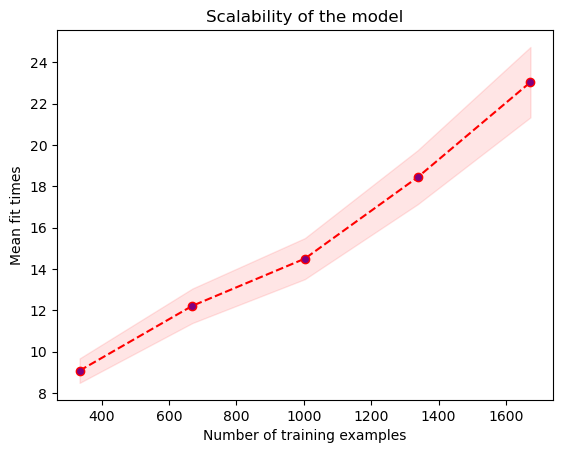

In [27]:
fig, ax=plt.subplots()

ax.plot(fit_times_rbf['cells'],fit_times_rbf['mean'],marker='o',markerfacecolor='purple',linestyle='dashed',color='red')
ax.fill_between(fit_times_rbf['cells'],fit_times_rbf['lower_ci'],fit_times_rbf['upper_ci'],color='red',alpha=.1)


plt.xlabel('Number of training examples')
plt.ylabel('Mean fit times')
plt.title('Scalability of the model')

path = folder_path+"fittimes_curve.jpg"
plt.savefig(path)

Balanced accuracy

In [28]:
samp_test_acc = [] 
samp_train_acc = []
for i in range(0,5):  
    test_acc=[]
    train_acc=[]
    for r in range(0,5):
        test_acc.append(all_[i].cv_results_['split'+str(r)+'_test_balanced_accuracy'][all_[i].best_index_]*100)
        train_acc.append(all_[i].cv_results_['split'+str(r)+'_train_balanced_accuracy'][all_[i].best_index_]*100)
    samp_test_acc.append(test_acc)
    samp_train_acc.append(train_acc)
    

In [29]:
# Rbf-SVM: Validation - calculate confidence interval (training balanced accuracy)

v_scaled_mean = [np.mean(i) for i in samp_train_acc]

v_total_CI = [st.t.interval(confidence=0.95,
                            df=len(i)-1,
                            loc=np.mean(i),
                            scale=st.sem(i)) for i in samp_train_acc]
v_lower_ci = [i[0] for i in v_total_CI]
v_upper_ci = [i[1] for i in v_total_CI]
cells = [int(i/100*data.shape[0]) for i in sampling]
train_rbf = pd.DataFrame({'mean':v_scaled_mean,
                           'lower_ci':v_lower_ci,
                            'upper_ci':v_upper_ci,
                           'cells':cells})

In [30]:
train_rbf

,mean,lower_ci,upper_ci,cells
0,87.605433,86.598147,88.612718,334
1,91.492742,90.964310,92.021174,669
2,88.212102,87.954342,88.469862,1003
3,85.440789,85.035538,85.846041,1338
4,86.300212,85.980541,86.619883,1673


In [31]:
# Rbf-SVM: Validation - calculate confidence interval 

v_scaled_mean = [np.mean(i) for i in samp_test_acc]

v_total_CI = [st.t.interval(confidence=0.95,
                            df=len(i)-1,
                            loc=np.mean(i),
                            scale=st.sem(i)) for i in samp_test_acc]
v_lower_ci = [i[0] for i in v_total_CI]
v_upper_ci = [i[1] for i in v_total_CI]
cells = [int(i/100*data.shape[0]) for i in sampling]
validation_rbf = pd.DataFrame({'mean':v_scaled_mean,
                           'lower_ci':v_lower_ci,
                            'upper_ci':v_upper_ci,
                           'cells':cells})

In [32]:
validation_rbf

,mean,lower_ci,upper_ci,cells
0,66.949495,58.455130,75.443860,334
1,69.237678,57.876184,80.599171,669
2,72.979727,65.438871,80.520582,1003
3,75.047211,68.463244,81.631178,1338
4,76.726232,70.877830,82.574635,1673


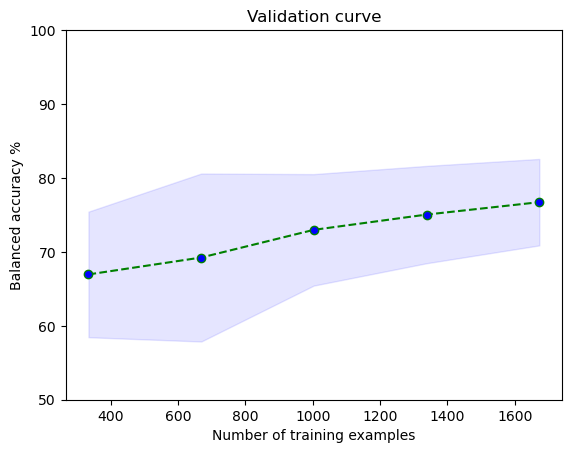

In [33]:
fig, ax=plt.subplots()
ax.plot(validation_rbf['cells'],validation_rbf['mean'],marker='o',markerfacecolor='blue',linestyle='dashed',color='green')
ax.fill_between(validation_rbf['cells'],validation_rbf['lower_ci'],validation_rbf['upper_ci'],color='b',alpha=.1)

plt.xlabel('Number of training examples')
plt.ylabel('Balanced accuracy %')
plt.title('Validation curve')
plt.ylim([50,100])

path = folder_path+"validation_curve_BA.jpg"
plt.savefig(path)

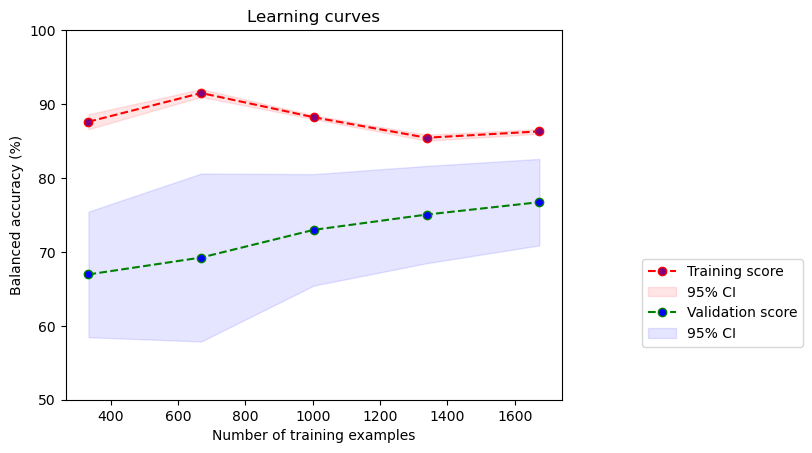

In [35]:
fig, ax=plt.subplots()

ax.plot(train_rbf['cells'],train_rbf['mean'],marker='o',markerfacecolor='purple',linestyle='dashed',color='red')
ax.fill_between(train_rbf['cells'],train_rbf['lower_ci'],train_rbf['upper_ci'],color='red',alpha=.1)

ax.plot(validation_rbf['cells'],validation_rbf['mean'],marker='o',markerfacecolor='blue',linestyle='dashed',color='green')
ax.fill_between(validation_rbf['cells'],validation_rbf['lower_ci'],validation_rbf['upper_ci'],color='b',alpha=.1)

plt.xlabel('Number of training examples')
plt.ylabel('Balanced accuracy (%)')
plt.title('Learning curves')
plt.legend(["Training score", "95% CI", "Validation score", "95% CI"],bbox_to_anchor=(1.5,0.4))
plt.ylim([50,100])

path = folder_path + "learning_curves_BA.jpg"
plt.savefig(path)

PR AUC

In [36]:
## Get train accuracies 
total_train =[] 
for s in range(0,5): # looping through sampling points 
    samp = all_[s]
    train_accuracies = [] 
    for i in range(0,10): # looping through 10 folds
        t = samp.cv_results_['split'+str(i)+'_train_PR_AUC'][samp.best_index_]*100
        train_accuracies.append(t)
    total_train.append(train_accuracies)
        

In [37]:
## Training - calculate confidence interval 
t_scaled_mean = [np.mean(i) for i in total_train]

t_total_CI = [st.t.interval(confidence=0.95, df=len(i)-1, loc=np.mean(i), scale=st.sem(i)) for i in total_train]

t_lower_ci = [i[0] for i in t_total_CI]
t_upper_ci = [i[1] for i in t_total_CI]
cells = [int(i/100*data.shape[0]) for i in sampling]
train_rbf_PR = pd.DataFrame({'mean':t_scaled_mean,
                           'lower_ci':t_lower_ci,
                            'upper_ci':t_upper_ci,
                           'cells':cells})

In [38]:
train_rbf_PR

,mean,lower_ci,upper_ci,cells
0,97.431656,97.283366,97.579946,334
1,98.487160,98.392495,98.581826,669
2,96.840436,96.748596,96.932275,1003
3,94.501898,94.404493,94.599302,1338
4,94.754171,94.665908,94.842433,1673


In [39]:
# Rbf-SVM: Validation - calculate confidence interval 

v_scaled_total = [] 
for t in total_: 
    s=[]
    for i in t: 
        i_=i *100
        s.append(i_)
    v_scaled_total.append(s) 
    
v_scaled_mean = [np.mean(i) for i in v_scaled_total]

v_total_CI = [st.t.interval(confidence=0.95,
                            df=len(i)-1,
                            loc=np.mean(i),
                            scale=st.sem(i)) for i in v_scaled_total]
v_lower_ci = [i[0] for i in v_total_CI]
v_upper_ci = [i[1] for i in v_total_CI]
cells = [int(i/100*data.shape[0]) for i in sampling]
validation_rbf_PR = pd.DataFrame({'mean':v_scaled_mean,
                           'lower_ci':v_lower_ci,
                            'upper_ci':v_upper_ci,
                           'cells':cells})

In [40]:
validation_rbf_PR

,mean,lower_ci,upper_ci,cells
0,78.947018,71.209556,86.684479,334
1,81.744068,76.896943,86.591192,669
2,81.775372,78.127771,85.422972,1003
3,83.163104,79.438521,86.887686,1338
4,83.660276,80.201906,87.118646,1673


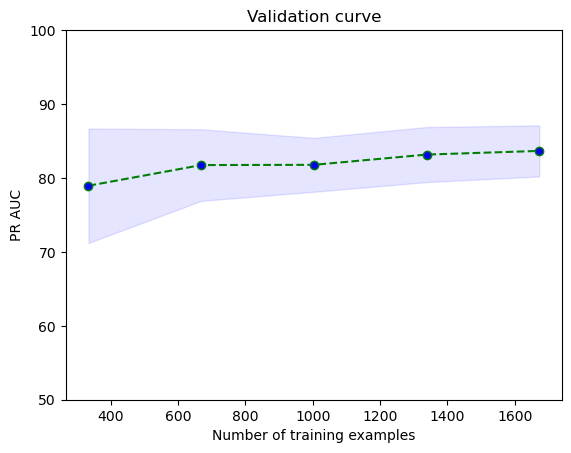

In [41]:
fig, ax=plt.subplots()
ax.plot(validation_rbf_PR['cells'],
        validation_rbf_PR['mean'],
        marker='o',markerfacecolor='blue',linestyle='dashed',color='green')
ax.fill_between(validation_rbf_PR['cells'],
                validation_rbf_PR['lower_ci'],
                validation_rbf_PR['upper_ci'],
                color='b',alpha=.1)

plt.xlabel('Number of training examples')
plt.ylabel('PR AUC')
plt.title('Validation curve')
plt.ylim([50,100])
path = folder_path+"validation_curve_PRAUC.jpg"
plt.savefig(path)

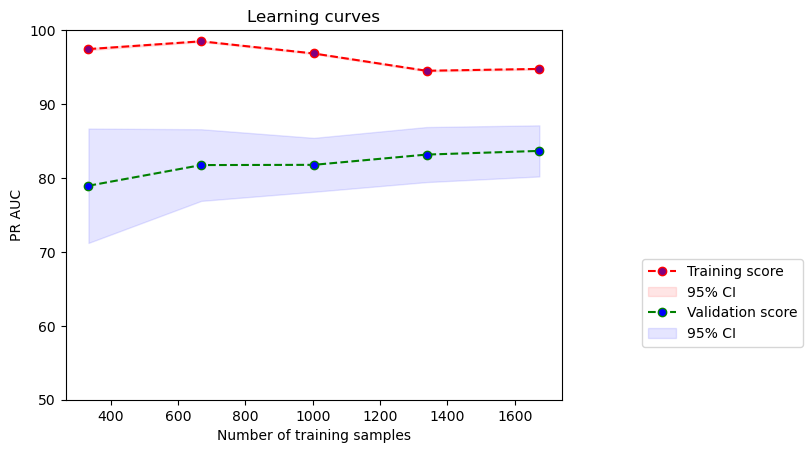

In [42]:
fig, ax=plt.subplots()

ax.plot(train_rbf_PR['cells'],
        train_rbf_PR['mean'],
        marker='o',markerfacecolor='purple',linestyle='dashed',color='red')
ax.fill_between(train_rbf_PR['cells'],
                train_rbf_PR['lower_ci'],
                train_rbf_PR['upper_ci'],
                color='red',alpha=.1)

ax.plot(validation_rbf_PR['cells'],
        validation_rbf_PR['mean'],
        marker='o',markerfacecolor='blue',linestyle='dashed',color='green')
ax.fill_between(validation_rbf_PR['cells'],
                validation_rbf_PR['lower_ci'],
                validation_rbf_PR['upper_ci'],
                color='b',alpha=.1)

plt.xlabel('Number of training samples')
plt.ylabel('PR AUC')
plt.title('Learning curves')
plt.legend(["Training score", "95% CI", "Validation score", "95% CI"],bbox_to_anchor=(1.5,0.4))
plt.ylim([50,100])

path = folder_path + "learning_curves_PRAUC.jpg"
plt.savefig(path)